In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import itertools
import os
import gc
import glob
import numba
import numpy.linalg as la
from scipy import stats
from scipy.stats import circmean
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Tie data from multiple h5 files

In [2]:
foldername = '0084'
n_inds = 30

window_size = '07' # sliding window size in seconds
fps = 30

In [3]:
names = sorted(glob.glob('/media/user/Samsung_T3/Work/Documents/Data/MGrobisData/' + str(n_inds) + '-fish/' + foldername + '/' + foldername + '_0*.h5'))

#### Get all pairwise data available from the trajectory data

In [4]:
i=0
for name in names:
    f = h5py.File(name, "r")
    group = f['fields/']

    vid_id = np.repeat(i, (group['x'].value).shape[0]*(group['x'].value).shape[1]*(group['x'].value).shape[0]).reshape((1,-1))
    frame = (np.repeat(np.tile(np.arange((group['x'].value).shape[1]), n_inds).reshape((1,-1)), n_inds)).reshape((1,-1))
    pos_x = (np.repeat((group['x'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    pos_y = (np.repeat((group['y'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    dir_x = (np.repeat((group['heading_x'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    dir_y = (np.repeat((group['heading_y'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    size = (np.repeat((group['body_length'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    ang_area_left = (group['ang_area_left_eye'].value).reshape((1,-1))
    ang_area_right = (group['ang_area_right_eye'].value).reshape((1,-1))
    ang_area = (group['ang_area_left_eye'].value).reshape((1,-1)) + (group['ang_area_right_eye'].value).reshape((1,-1))
    
    for fr in range(0,group['x'].shape[1]):
        X = np.array([group['x'].value, group['y'].value])[...,fr].T
        sum_X = np.sum(np.square(X), axis=1)
        D = np.sqrt(np.maximum(0.0, sum_X + sum_X[:,None] + -2 * X.dot(X.T)))
        D *= 1 - np.eye(D.shape[0])
        if fr == 0:
            dtmp = np.array([np.repeat(fr, n_inds*n_inds), D.reshape((-1,))])
        else:
            dtmp = np.hstack((dtmp, np.array([np.repeat(fr, n_inds*n_inds), D.reshape((-1,))])))
    dtmp = np.vstack([vid_id, dtmp]).T
    
    tmp = np.squeeze(np.array([vid_id, frame, pos_x, pos_y, dir_x, dir_y, size, ang_area])).T
    if i != 0:
        tmp_curr = pd.DataFrame(tmp, columns=['vid_id', 'frame', 'x', 'y', 'dir_x', 'dir_y', 'size', 'ang_area'])
        tmp_min = tmp_curr[tmp_curr['frame'] == 0]
        tmp_min = tmp_min.drop_duplicates(subset='x', keep="last")
        tmp_max = tmp_prev[tmp_prev['frame'] == max(tmp_prev['frame'])]
        tmp_max = tmp_max.drop_duplicates(subset='x', keep="last")
        
        last = list(np.array([tmp_max['x'],tmp_max['y']]).T)
        this = list(np.array([tmp_min['x'],tmp_min['y']]).T)
        
        cost = cdist(this,last)
        orig_ids, new_idx = linear_sum_assignment(cost)
        new_ids = tmp_max['f_id'].values[new_idx]
        
        del tmp
        del tmp_prev
        del tmp_min
        del tmp_max
        del cost
        gc.collect()
        
        tmp_curr['f_id'] = np.repeat(new_ids, (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        tmp_curr['n_id'] = np.tile(new_ids, (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        df = pd.concat([df,tmp_curr])
        tmp_prev = tmp_curr
        
        fid = np.tile(np.repeat(new_ids, n_inds), (group['x'].value).shape[1]).reshape((-1,1))
        nid = np.tile(new_ids, n_inds*(group['x'].value).shape[1]).reshape((-1,1))
        dtmp = np.hstack((dtmp, fid, nid))
        dists = np.append(dists, dtmp, axis=0)
    else:
        fid = np.repeat(np.arange(n_inds), (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        nid = np.tile(np.arange(n_inds), (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        data = np.hstack((tmp, fid, nid))
        df = pd.DataFrame(data, columns=['vid_id', 'frame', 'x', 'y', 'dir_x', 'dir_y', 'size', 'ang_area', 'f_id', 'n_id'])
        tmp_prev = df
        
        fid = np.tile(np.repeat(np.arange(n_inds), n_inds), (group['x'].value).shape[1]).reshape((-1,1))
        nid = np.tile(np.arange(n_inds), n_inds*(group['x'].value).shape[1]).reshape((-1,1))
        dists = np.hstack((dtmp, fid, nid))
    
    i = i+1

dists = pd.DataFrame(dists, columns=['vid_id', 'frame', 'dist', 'f_id', 'n_id'])
print(df.shape[0] - df.dropna().shape[0]) # print number of rows with nas (this should be 0)

/home/user/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


0


In [5]:
del vid_id
del frame
del pos_x
del pos_y
del dir_x
del dir_y
del size
del ang_area_left
del ang_area_right
gc.collect()

14

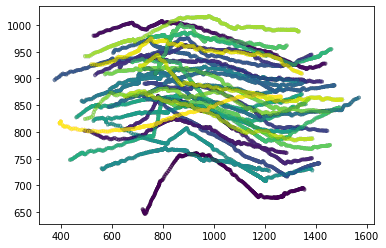

In [6]:
df_plot = df[(df['frame'] < 200) & (df['vid_id'] == 0)]

plt.scatter(df_plot['x'], df_plot['y'], c=df_plot['f_id'].values, s=10, alpha=0.02)
plt.show()

In [7]:
for i in np.unique(df['vid_id']):
    if i != 0:
        df.iloc[np.where(df['vid_id'] == i)[0],1] += (max(df[df['vid_id'] == i-1]['frame']) + 1)

for i in np.unique(dists['vid_id']):
    if i != 0:
        dists.iloc[np.where(dists['vid_id'] == i)[0],1] += (max(dists[dists['vid_id'] == i-1]['frame']) + 1)
        
for idx in np.unique(df['f_id']):
    tmp = df.iloc[np.where(df['f_id'] == idx)[0],:]
    df.loc[df['f_id'] == idx,'pos_x'] = np.nanmean([tmp['x'].shift(-2*n_inds), tmp['x'].shift(-n_inds), tmp['x'], tmp['x'].shift(n_inds), tmp['x'].shift(2*n_inds)], axis=0)
    df.loc[df['f_id'] == idx,'pos_y'] = np.nanmean([tmp['y'].shift(-2*n_inds), tmp['y'].shift(-n_inds), tmp['y'], tmp['y'].shift(n_inds), tmp['y'].shift(2*n_inds)], axis=0)
    
for idx in np.unique(df['f_id']):
    tmp = df.iloc[np.where(df['f_id'] == idx)[0],:]
    df.loc[df['f_id'] == idx,'vx'] = tmp['pos_x'] - tmp['pos_x'].shift(n_inds)
    df.loc[df['f_id'] == idx,'vy'] = tmp['pos_y'] - tmp['pos_y'].shift(n_inds)
    df.loc[df['f_id'] == idx,'speed'] = np.sqrt(df.loc[df['f_id'] == idx,'vx']**2 + df.loc[df['f_id'] == idx,'vy']**2)
    
for idx in np.unique(df['f_id']):
    tmp = df.iloc[np.where(df['f_id'] == idx)[0],:]
    df.loc[df['f_id'] == idx,'acc_x'] = tmp['vx'] - tmp['vx'].shift(n_inds)
    df.loc[df['f_id'] == idx,'acc_y'] = tmp['vy'] - tmp['vy'].shift(n_inds)
    df.loc[df['f_id'] == idx,'acceleration'] = np.sqrt(df.loc[df['f_id'] == idx,'acc_x']**2 + df.loc[df['f_id'] == idx,'acc_y']**2)

df = pd.merge(df, dists, how='left')
df.head()

,vid_id,frame,x,y,dir_x,dir_y,size,ang_area,f_id,n_id,pos_x,pos_y,vx,vy,speed,acc_x,acc_y,acceleration,dist
0,0.0,0.0,720.128294,655.353984,0.727631,-0.685968,59.566278,0.000000,0.0,0.0,722.236146,653.085887,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0.0,0.0,720.128294,655.353984,0.727631,-0.685968,59.566278,0.000000,0.0,1.0,722.236146,653.085887,NaN,NaN,NaN,NaN,NaN,NaN,377.526731
2,0.0,0.0,720.128294,655.353984,0.727631,-0.685968,59.566278,0.065973,0.0,2.0,722.236146,653.085887,NaN,NaN,NaN,NaN,NaN,NaN,271.389786
3,0.0,0.0,720.128294,655.353984,0.727631,-0.685968,59.566278,0.339292,0.0,3.0,722.236146,653.085887,NaN,NaN,NaN,NaN,NaN,NaN,165.418226
4,0.0,0.0,720.128294,655.353984,0.727631,-0.685968,59.566278,0.000000,0.0,4.0,722.236146,653.085887,NaN,NaN,NaN,NaN,NaN,NaN,313.050843


In [8]:
tmp = df.loc[:,["f_id", "size"]]

tmp_ord = tmp.groupby(['f_id']).median()
tmp_ord = tmp_ord.reset_index()
tmp_ord = tmp_ord.rename(index=str, columns={'size':'fsize'})

df = pd.merge(df, tmp_ord, how='left')

In [9]:
cols = ['x', 'y', 'vx', 'vy', 'acc_x', 'acc_y', 'size']
df.drop(cols, axis=1, inplace=True)

gc.collect()

2596

In [10]:
n_df = df.loc[:,['vid_id', 'frame', 'f_id', 'pos_x', 'pos_y', 'fsize', 'speed', 'acceleration']]
n_df = n_df.rename(index=str, columns={'vid_id':'vid_id', 'frame':'frame', 'f_id':'n_id', 'pos_x':'npos_x', 'pos_y':'npos_y', 'fsize':'n_size', 'speed':'n_speed', 'acceleration':'n_acceleration'})
n_df = n_df.drop_duplicates()

df = pd.merge(df,n_df)

del n_df
gc.collect()

42

In [11]:
df['size_diff'] = df['n_size'] - df['fsize']
df['speed_diff'] = df['n_speed'] - df['speed']
df['acc_diff'] = df['n_acceleration'] - df['acceleration']

In [12]:
tmp = df.loc[:,["frame", "speed", "acceleration"]]

tmp_ord = tmp.groupby(['frame']).median()
tmp_ord = tmp_ord.reset_index()
tmp_ord = tmp_ord.rename(index=str, columns={'speed':'gspeed', 'acceleration':'gacc'})

df = pd.merge(df, tmp_ord, how='left')

df['dev_gspeed'] = df['speed'] - df['gspeed']
df['dev_ngspeed'] = df['n_speed'] - df['gspeed']
df['dev_gacc'] = df['acceleration'] - df['gacc']
df['dev_ngacc'] = df['n_acceleration'] - df['gacc']

In [13]:
tmp = df.loc[:,["frame", "pos_x", "pos_y", "dir_x", "dir_y"]]

tmp_ord = tmp.groupby(['frame']).mean()
tmp_ord = tmp_ord.reset_index()
tmp_ord = tmp_ord.rename(index=str, columns={'pos_x':'centroid_x', 'pos_y':'centroid_y', 'dir_x':'gdir_x', 'dir_y':'gdir_y'})

df = pd.merge(df, tmp_ord, how='left')
df.head()

,vid_id,frame,dir_x,dir_y,ang_area,f_id,n_id,pos_x,pos_y,speed,...,gspeed,gacc,dev_gspeed,dev_ngspeed,dev_gacc,dev_ngacc,centroid_x,centroid_y,gdir_x,gdir_y
0,0.0,0.0,0.727631,-0.685968,0.000000,0.0,0.0,722.236146,653.085887,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,594.864432,867.318755,0.902413,0.146048
1,0.0,0.0,0.970926,0.239381,0.000000,1.0,0.0,532.456445,980.046348,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,594.864432,867.318755,0.902413,0.146048
2,0.0,0.0,0.914995,-0.403466,0.075398,2.0,0.0,499.334007,802.173172,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,594.864432,867.318755,0.902413,0.146048
3,0.0,0.0,0.994175,0.107780,0.191637,3.0,0.0,653.922899,805.698596,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,594.864432,867.318755,0.902413,0.146048
4,0.0,0.0,0.999689,0.024939,0.000000,4.0,0.0,538.508502,908.576574,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,594.864432,867.318755,0.902413,0.146048


In [14]:
df['centred_x'] = df['pos_x'] - df['centroid_x']
df['centred_y'] = df['pos_y'] - df['centroid_y']
df['rotated_x'] = df['rotated_y'] = 0
df['ang'] = np.arctan2(df['gdir_y'], df['gdir_x'])

@numba.njit(fastmath=True, parallel=True)
def parallel_rotate(xy, rmat):
    out = np.zeros(xy.shape)
    for idx in numba.prange(xy.shape[0]):
        out[idx] = np.dot(rmat[idx], xy[idx])
    return out

In [15]:
xy = df[['centred_x', 'centred_y']].values
angles = df['ang'].values
rmat = np.array([[np.cos(angles), -np.sin(angles)], [np.sin(angles), np.cos(angles)]]).T

df['rotated_x'], df['rotated_y'] = parallel_rotate(xy, rmat).T

In [16]:
cols = ['n_size', 'n_speed', 'n_acceleration', 'gspeed', 'gacc', 'gdir_x', 'gdir_y', 'centred_x', 'centred_y', 'ang']
df.drop(cols, axis=1, inplace=True)

gc.collect()

14559

In [17]:
df['npx'] = df['npos_x'] - df['pos_x']
df['npy'] = df['npos_y'] - df['pos_y']
df['ang'] = np.arctan2(tmp['dir_y'],tmp['dir_x'])

In [18]:
xy = df[['npx', 'npy']].values
angles = df['ang'].values
rmat = np.array([[np.cos(angles), -np.sin(angles)], [np.sin(angles), np.cos(angles)]]).T

df['rel_pos_x'], df['rel_pos_y'] = parallel_rotate(xy, rmat).T

df['dist'] = np.sqrt(df['rel_pos_x']**2 + df['rel_pos_y']**2)
df['ang_pos_x'] = df['rel_pos_x'] / df['dist']
df['ang_pos_y'] = df['rel_pos_y'] / df['dist']

del tmp_ord
gc.collect()

55

In [19]:
cols = ['npx', 'npy', 'npos_x', 'npos_y', 'ang', 'centroid_x', 'centroid_y', 'rel_pos_x', 'rel_pos_y']
df.drop(cols, axis=1, inplace=True)
df.head()

,vid_id,frame,dir_x,dir_y,ang_area,f_id,n_id,pos_x,pos_y,speed,...,speed_diff,acc_diff,dev_gspeed,dev_ngspeed,dev_gacc,dev_ngacc,rotated_x,rotated_y,ang_pos_x,ang_pos_y
0,0.0,0.0,0.727631,-0.685968,0.000000,0.0,0.0,722.236146,653.085887,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,91.509339,-231.830361,NaN,NaN
1,0.0,0.0,0.970926,0.239381,0.000000,1.0,0.0,532.456445,980.046348,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-43.596761,121.250111,0.280372,-0.959891
2,0.0,0.0,0.914995,-0.403466,0.075398,2.0,0.0,499.334007,802.173172,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-104.711197,-49.046655,0.984864,-0.173329
3,0.0,0.0,0.994175,0.107780,0.191637,3.0,0.0,653.922899,805.698596,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,48.455309,-70.264000,0.307807,-0.951449
4,0.0,0.0,0.999689,0.024939,0.000000,4.0,0.0,538.508502,908.576574,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-49.040619,49.731439,0.563403,-0.826182


In [20]:
df.to_csv('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/golden_shiners/' + str(n_inds) + '_fish/' + foldername + '/' + 'alltracks.csv', mode='w')